

# Note:
For the sake of readability, I intentionally ommitted much of the code used to train and save models from this notebook.  All of the code used to train the saved models that this notebook loads can be found in the "Model Training" notebook within this same GitHub repository

# Dependencies

In [ ]:
%%capture
!pip install ktrain
!pip install -q -U keras-tuner

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import models, layers
import keras_tuner as kt
import ktrain
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

sns.set_style("darkgrid")
%matplotlib inline

---
# Dataset and task description

For this project, I will build and tune CNN classification models for the Fashion-MNIST dataset. The Fashion-MNIST dataset was created to replace the famous &mdash; but dated &mdash; MNIST handwritten digit dataset as a benchmark for image classification models.  

The Fashion-MNIST dataset is comprised of 60,000 training images and 10,000 test images. All images are 28x28 pixels with a single "grayscale" color channel.  Images are evenly distributed between 10 labels:  T-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. This classification task is designed to be difficult/impossible to achieve near-perfect test accuracy, but it is still a “real-world” dataset rather than an arbitrarily difficult synthetic dataset.

My primary goal in this project is to gain experience using hyperparameter tuning techniques to optimize models for a specific task.  In particular, I will refine models based on VGG-Net and ResNet architectures.  

My model tuning will consider:
* architectural hyperparameters (blocks, layers, filters)
* optimization hyperparameters (learning rate, learning rate scheduling)
* training data augmentation

> *Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms.* Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747 https://github.com/zalandoresearch/fashion-mnist

In [ ]:
#load Fashion-MNIST from TensorFlow
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
# Directory for saving/loading models and their training histories
PROJECT_DIR = "/content/drive/MyDrive/!Data/fashion/"

---
# EDA

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
# display compact table of training label value counts
label_values, label_counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({"labels":label_values, "counts":label_counts}).T.style.hide_columns()

labels,0,1,2,3,4,5,6,7,8,9
counts,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000


As demonstrated in the cells above, the 60,000 training are perfectly balanced with 6000 samples for each of the 10 labels.  No labels are missing.

The images are already in the 2-dimensional 28x28 pixel shape that is ideal for our CNN models, so we don't need to reshape them.

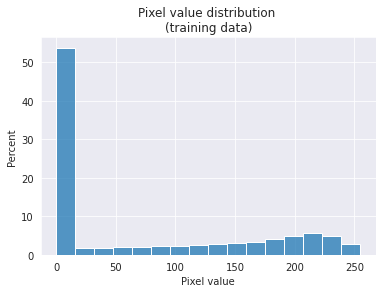

In [ ]:
# show pixel value distribution
pixel_values, pixel_counts = np.unique(train_images, return_counts=True)
sns.histplot(x=pixel_values, weights=pixel_counts, stat="percent", bins=16)
plt.title("Pixel value distribution \n(training data)")
plt.xlabel("Pixel value")
plt.show()

All pixel values are integers in the range [0-255].  No pixel values are missing or in the wrong format, so no data cleaning is necessarily.  

Almost half of the pixels are 0 (or very close to it) which corresponds to black "empty" pixels.

I will rescale the pixel values from [0,255] to [0,1] since it may help the models converge faster during training.

In [ ]:
# normalize pixel values 
train_images = train_images/255
X_test = X_test/255

## Label visualizations

In [ ]:
# dict for mapping label number to name
label_lookup = {0:"T-shirt",1: 'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5: 'Sandal',6: 'Shirt',7: 'Sneaker',8: 'Bag',9: 'Ankle boot'}

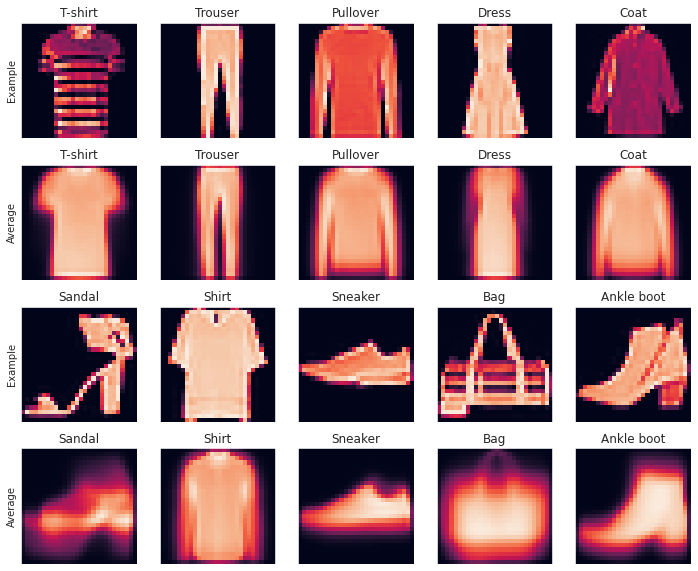

In [ ]:
def show_example_images(imgs,labels):
    items = []
    mean_items = [] 

    for i in range(10):
        subset_dims=imgs[labels==i].shape

        item = imgs[labels==i][np.random.randint(0,subset_dims[0])]
        items.append(item)

        mean_item = np.mean(imgs[labels==i], axis=0)
        mean_items.append(mean_item)

    fig, axs = plt.subplots(nrows=4,ncols=5, sharey="row", sharex="col", figsize=(12,10))
    for i, img in enumerate(items[:5]): # row 1
        axs[0,i].imshow(img); axs[0,i].set_title(label_lookup[i]); axs[0,i].grid(None)
    for i, img in enumerate(mean_items[:5]): # row 2
        axs[1,i].imshow(img); axs[1,i].set_title(label_lookup[i]); axs[1,i].grid(None)
    for i, img in enumerate(items[5:]): # row 3
        axs[2,i].imshow(img); axs[2,i].set_title(label_lookup[i+5]); axs[2,i].grid(None)
    for i, img in enumerate(mean_items[5:]): # row 4
        axs[3,i].imshow(img); axs[3,i].set_title(label_lookup[i+5]); axs[3,i].grid(None)
    fig.axes[0].set_ylabel("Example"); fig.axes[0].set_yticks([])
    fig.axes[5].set_ylabel("Average"); fig.axes[5].set_yticks([])
    fig.axes[10].set_ylabel("Example"); fig.axes[10].set_yticks([])
    fig.axes[15].set_ylabel("Average"); fig.axes[15].set_yticks([])
    for x in range(5):
        fig.axes[x].set_xticks([])
    # plt.savefig("image_grid.png", bbox_inches='tight') # save this plot
    plt.show()

show_example_images(train_images, train_labels)

The previous graphic shows an example item from each of the 10 labels as well as the "average item" for each label.

From this plot, we can see that the **average shirt**, **average coat**, and **average pullover** look very similar.  Additionally, the **average dress** shows very light sleeves, which suggest that there may be a great deal of variation in the silhouette of that label's arms.  These observations suggest that our model may struggle to correctly distinguish between these labels.

Perhaps surprisingly, the averages of the 3 footwear categories are not very similar.

---
## Preparing train and validation sets

I will split the training images into training and validation subsets in a stratified manner in order to preserve the balance between labels.

In [ ]:
# split the training data into training and validation sets (with balanced labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels)

Note: Keras `ImageDataGenerator` objects severely slowed down model training; therefore, I will perform data augmentation from within the models using Keras image augmentation layers.

In [ ]:
# utility function to plot training history
def training_plots(df, model, title, X_val=X_val, y_val=y_val):
    cm=None

    preds = model.predict(X_val)
    preds = np.argmax(preds, axis=1)

    # Loss subplot
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
    ax[0].plot("epoch", "loss", data = df)
    ax[0].plot("epoch", "val_loss", data = df)
    fig.axes[0].set_ylabel('loss')
    fig.axes[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

    # accuracy subplot
    ax[1].plot("epoch", "accuracy", data = df)
    ax[1].plot("epoch", "val_accuracy", data = df)
    fig.axes[1].set_ylabel('accuracy')
    fig.axes[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    # confusion matrix - normalized by predictions/accuracy (columns)
    cm = pd.DataFrame(confusion_matrix(y_val, preds, normalize="pred")) #confusion_matrix annotations; precision

    for col in cm.columns:
        # hide very small values to improve readability
        cm[col] = cm[col].apply(lambda x: "" if x <=.005 else str(round(x,2)))

    heatmap = sns.heatmap(
        data=confusion_matrix(y_val, preds, normalize="pred"), # precision
        annot=cm, fmt="",
        cmap="viridis",
        linewidths=1.0,
        vmax=1,vmin=0,
        xticklabels=["T-shirt", 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot'],
        yticklabels=["T-shirt", 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot'],
        ax=ax[2])
    heatmap.xaxis.tick_bottom()
    heatmap.tick_params(length=0)
    plt.xticks(rotation = 45)
    plt.yticks(rotation=0)
    plt.title("Normalized by column")
    fig.axes[2].set_ylabel("True label")
    fig.axes[2].set_xlabel("Predicted label")
    if title:
        plt.suptitle(title)
    plt.show()


---
# Models

Rather than manually choosing the hyperparameters for my CNN models, I will use `keras-tuner` to find well-performing hyperparameter combinations. To use `keras-tuner` we must first write functions to return models to the hyperparameter tuner.

## VGG-Net builder

In [ ]:
def vgg_conv_block(x, filters, drop_channel, bn, conv_layers):
    for _ in range(conv_layers):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if drop_channel:
            x = layers.SpatialDropout2D(drop_channel)(x)
    x = layers.MaxPool2D((2,2))(x)
    return x

def fc_layers(x, fc_size_list, drop_neuron, bn):
    x = layers.Flatten()(x)
    if drop_neuron:
        x=layers.Dropout(drop_neuron)(x)
    for fc in fc_size_list:
        x = layers.Dense(fc)(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if drop_neuron:
            x=layers.Dropout(drop_neuron)(x)
    
    x = layers.Dense(10, activation="softmax", kernel_initializer=tf.keras.initializers.he_uniform)(x)
    return x

def get_vgg_model(
    conv_blocks, # each block doubles the number of filters and halves the dimensions of the feature maps
    fc_size_list, # list of units for a FC layer 
    name, #model name
    conv_layers=2,  # layers to appear in each conv_block
    bn=True, # apply batch normalization after convolution layers?
    starting_filters=32, # filters for the first conv_block
    drop_channel=False, # if float value, include SpatialDropout2D layer before MaxPool 
    drop_neuron=False, # if float value, include Dropout layer before Dense layers
    data_aug=False # apply data augmentation layers during training?
    ):

    filters = starting_filters
    img_input = layers.Input(shape=(28,28,1), name="img_input")
    x = img_input

    if data_aug:
        x = layers.RandomFlip(mode="horizontal")(x)
        x = layers.RandomZoom(0.06, fill_mode="constant", fill_value=0.0, interpolation="nearest" )(x)
        x = layers.RandomTranslation(0.06, 0.06, fill_mode="constant", fill_value=0.0, interpolation="nearest")(x)

    for _ in range(conv_blocks):
        x = vgg_conv_block(x, filters=filters, drop_channel=drop_channel, bn=bn, conv_layers=conv_layers)
        filters *= 2
    
    x = fc_layers(x, fc_size_list=fc_size_list, drop_neuron=drop_neuron, bn=bn)

    model = models.Model(img_input, x, name=name)
    return model




## ResNet builder



In [ ]:

def residual_block(x, filters, res_block_layers, drop_channel=False):
    x_ = x #initial input, saved for skip connection
    
    for layer in range(res_block_layers-1):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if drop_channel:
            x = layers.SpatialDropout2D(drop_channel)(x)

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x_, x])
    x = layers.Activation("relu")(x)
    if drop_channel:
        x = layers.SpatialDropout2D(drop_channel)(x)

    return x

def resnet_downsample_block(x, filters):
    x_ = x #initial input, saved for skip connection

    x = layers.Conv2D(filters=filters, strides=(2,2), kernel_size=(3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters=filters, strides=(1,1), kernel_size=(3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x_ = layers.Conv2D(filters=filters, strides=(2,2), kernel_size=(1,1), padding="valid")(x_)
    x_ = layers.BatchNormalization()(x_)

    x = layers.Add()([x_, x])
    x = layers.Activation("relu")(x)

    return x

def get_resnet_model(
    downsample_blocks, # each downsampling block doubles the number of filters and halves the dimensions of the feature maps
    name, # model name
    starting_filters=32, # filters in first block
    res_block_layers=2, # layers in each residual block
    drop_channel=False, # if float, SpatialDropout2D between residual block layers.
    data_aug=False # apply data augmentation layers during training?
    ):
    filters = starting_filters
    img_input = layers.Input(shape=(28,28,1), name="img_input")
    x = img_input

    if data_aug:
        x = layers.RandomFlip(mode="horizontal")(x)
        x = layers.RandomZoom(0.06, fill_mode="constant", fill_value=0.0, interpolation="nearest" )(x)
        x = layers.RandomTranslation(0.06, 0.06, fill_mode="constant", fill_value=0.0, interpolation="nearest")(x)


    for block in range(downsample_blocks):
        x = residual_block(x, filters=filters, res_block_layers=res_block_layers, drop_channel=drop_channel)
        filters *= 2
        x = resnet_downsample_block(x, filters=filters)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10, activation="softmax", kernel_initializer=tf.keras.initializers.he_uniform)(x)

    model = models.Model(img_input, x, name=name)
    return model

---
## Hyperparameter tuning with Keras-tuner



## VGG-Net hyperparameter search
VGG-Net hyperparameter search space includes:
* `conv_blocks` - [2, 3, 4]
* `fc_size_list[i]` - [32, 64, 96, 128]
* `conv_layers` - [2, 3, 4]
* `bn` - [True, False]
* `starting_filters` - [16, 22, 28, 34, 40, 46, 52, 58, 64]
* `drop_channel` - [0, 0.1, 0.2, 0.3, 0.4]
* `drop_neuron` - [0, 0.1, 0.2, 0.3, 0.4, 0.5]
* `learning_rate` - [1e-2, 1e-3, 1e-4, 1e-5]


In [ ]:
# Keras-tuner will use this function to build VGG variants with specified hyperparameters
def vgg_builder(hp):
    model = get_vgg_model(
        conv_blocks=hp.Int("blocks", min_value=2, max_value=4,step=1), 
        fc_size_list=[hp.Int("fc_1",min_value=32, max_value=128, step=32),
                      hp.Int("fc_2",min_value=32, max_value=128, step=32)], 
        name="vgg_hp_tuning_candidate", 
        conv_layers=hp.Int("conv_block_layers", min_value=2, max_value=4, step=1), 
        bn=hp.Boolean("bn", default=True), 
        starting_filters=hp.Int("starting_filters", min_value=16, max_value=64,step=6) , 
        drop_channel=hp.Float("drop_channel", min_value=0.0, max_value=0.4, step = 0.1, default=0.0), 
        drop_neuron=hp.Float("drop_neuron", min_value=0.0, max_value=0.5, step = 0.1, default=0.0))
    
    model.compile(    
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", values=[1e-2, 1e-3, 1e-4, 1e-5])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
    
    return model

In [ ]:
#Keras-tuner object that will conduct the hyperparameter search
vgg_tuner = kt.Hyperband(vgg_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     seed=1,
                     directory=PROJECT_DIR,
                     project_name='cnn_fashion')

vgg_tuner.search(x=(X_train, y_train), validation_data=(X_val, y_val), 
    epochs=40,
    batch_size=32
)

Trial 30 Complete [00h 10m 15s]
val_accuracy: 0.9181666374206543

Best val_accuracy So Far: 0.9331666827201843
Total elapsed time: 01h 56m 14s


## VGG-Net hyperparameter tuning results:
### Top-3 trials after 20 training epochs

| best val_accuracy | conv_blocks | fc_size_list | conv_layers | bn | starting_filters | drop_channel | drop_neuron | learning_rate |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.9332 | 3  | [64, 64]  | 3  | True | 64  | 0.1  | 0.3  | .001  |
| 0.9278 | 2 | [64, 96]  | 2 | True  | 22  | 0.2  | 0 | .001  |
| 0.9273 | 2  | [96, 64]  | 3  | True  | 34  | 0  | 0.3  | .01  |

Each of the top-3 trials utilized batch normalization.  The success of batch normalization isn't a surprise on its own, but I find it interesting that it was useful even with channel- *and* neuron-level dropout.

None of the most successful models used 4 conv_blocks or 4 conv_layers.  All 3 models utilized the "medium" fc_layer options of 64 and/or 96 units per layer

**Note:** This hyperparameter search algorithm used an efficient strategy to cover as much of the search space as possible, but it did NOT exhaustively search all combinations of hyperparameters.

## Retrain and compare Top-3 VGG-Net models

**Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.

In [ ]:
# load saved model histories
df_vgg_1 = pd.read_csv(PROJECT_DIR+"history_vgg_1.csv")
df_vgg_2 = pd.read_csv(PROJECT_DIR+"history_vgg_2.csv")
df_vgg_3 = pd.read_csv(PROJECT_DIR+"history_vgg_3.csv")

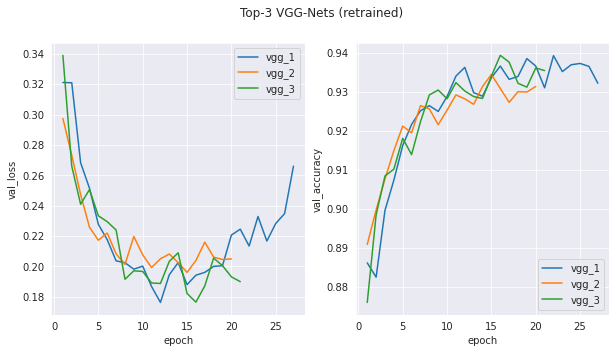

In [ ]:
# plot top-3 VGG-Nets
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "val_loss", data=df_vgg_1, label="vgg_1")
ax[0].plot("epoch", "val_loss", data=df_vgg_2, label="vgg_2")
ax[0].plot("epoch", "val_loss", data=df_vgg_3, label="vgg_3")
fig.axes[0].set_ylabel('val_loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "val_accuracy", data=df_vgg_1, label="vgg_1")
ax[1].plot("epoch", "val_accuracy", data=df_vgg_2, label="vgg_2")
ax[1].plot("epoch", "val_accuracy", data=df_vgg_3, label="vgg_3")
fig.axes[1].set_ylabel('val_accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("Top-3 VGG-Nets (retrained)")

plt.show()

---
## ResNet hyperparameter search
ResNet hyperparameter search space includes:
* `downsample_blocks` - [2, 3]
* `starting_filters` - [32, 48, 64]
* `res_block_layers` - [2, 3, 4, 5, 6]
* `drop_channel` - [0, 0.1, 0.2, 0.3, 0.4]
* `learning_rate` - [1e-3, 1e-4, 1e-5]

In [ ]:
# Keras-tuner will use this function to build ResNet variants with specified hyperparameters
def resnet_builder(hp):
    model = get_resnet_model(
        downsample_blocks = hp.Choice("downsample_blocks", values=[2,3]), 
        name = "resnet_hyperband_candidate",
        starting_filters=hp.Choice("starting_filters", [32,48,64]), 
        res_block_layers=hp.Int("res_block_layers", min_value=2, max_value=6, step=1),
        drop_channel=hp.Float("drop_channel", min_value=0.0, max_value=0.4, step = 0.1)
    )

    model.compile(    
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", values=[1e-3, 1e-4, 1e-5])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
    
    return model

In [ ]:
#Keras-tuner object that will conduct the hyperparameter search
resnet_tuner = kt.Hyperband(resnet_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     seed=1,
                     directory=PROJECT_DIR,
                     project_name='cnn_fashion_resnet')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
resnet_tuner.search(x=(X_train, y_train), validation_data=(X_val, y_val), 
    epochs=40,
    batch_size=32,
    callbacks=[early_stop]
)

Trial 30 Complete [00h 17m 24s]
val_accuracy: 0.9369166493415833

Best val_accuracy So Far: 0.9392499923706055
Total elapsed time: 03h 21m 58s


## ResNet hyperparameter tuning results:
### Top-3 trials after 20 training epochs

| best val_accuracy | downsample_blocks | starting_filters | res_block_layers | drop_channel | learning_rate |
| --- | --- | --- | --- | --- | --- |
| 0.9392 | 3  | 48 | 3  | 0| .001 |
| 0.9374| 3 | 32  | 3| 0.2  | .001  |
| 0.9369 | 3  | 32  | 3  | 0.1  | .0001  |

There top performing models have fairly homogenous hyperparameters compared to the VGG-Net trials.  Perhaps that shouldn't be surprising given the smaller search space for the ResNet models.

All 3 of the best models have the same number of blocks and layers, which lends confidence that those hyperparameters are well suited for this specific task.  The top 3 models had extremely similar scores, so their relative ranking may be due to random chance.

## Retrain and compare Top-3 ResNet models
**Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.

In [ ]:
# save model historys
df_resnet_1 = pd.read_csv(PROJECT_DIR+"history_resnet_1.csv")
df_resnet_2 = pd.read_csv(PROJECT_DIR+"history_resnet_2.csv")
df_resnet_3 = pd.read_csv(PROJECT_DIR+"history_resnet_3.csv")

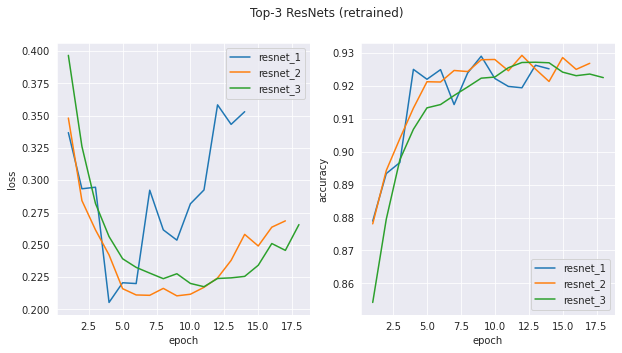

In [ ]:
# plot top-3 resnets
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "val_loss", data=df_resnet_1, label="resnet_1")
ax[0].plot("epoch", "val_loss", data=df_resnet_2, label="resnet_2")
ax[0].plot("epoch", "val_loss", data=df_resnet_3, label="resnet_3")
fig.axes[0].set_ylabel('loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "val_accuracy", data=df_resnet_1, label="resnet_1")
ax[1].plot("epoch", "val_accuracy", data=df_resnet_2, label="resnet_2")
ax[1].plot("epoch", "val_accuracy", data=df_resnet_3, label="resnet_3")
fig.axes[1].set_ylabel('accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("Top-3 ResNets (retrained)")

plt.show()

---
# Augmented Data

# Retrain best VGG-Net with augmented data (vgg_1)

**Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.



In [ ]:
# load saved training history
df_vgg_1_aug = pd.read_csv(PROJECT_DIR+"history_vgg_1_aug.csv")

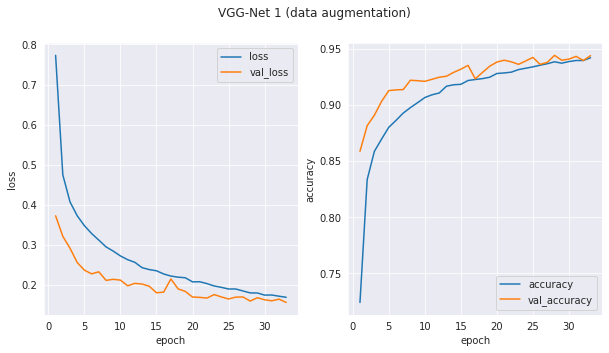

In [ ]:
# plot training history
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "loss", data=df_vgg_1_aug, label="loss")
ax[0].plot("epoch", "val_loss", data=df_vgg_1_aug, label="val_loss")
fig.axes[0].set_ylabel('loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "accuracy", data=df_vgg_1_aug, label="accuracy")
ax[1].plot("epoch", "val_accuracy", data=df_vgg_1_aug, label="val_accuracy")
fig.axes[1].set_ylabel('accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("VGG-Net 1 (data augmentation)")

plt.show()

**Note:** Based on the plot, the VGG-Net I may have set too aggressive of an early stopping callback.  The validation loss/accuracy hadn't been overtaken by the training loss/accuracy, so it may have kept improving with additional epochs

# Retrain most promising ResNet model with augmented data (resnet_2)

I'm choosing to go with resnet_2 instead of resnet_1 because both models had similar performance, but resnet_1's training was less stable and its training epochs took a little longer.

**Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.

In [ ]:
# load saved training history
df_resnet_2_aug = pd.read_csv(PROJECT_DIR+"history_resnet_2_aug.csv")

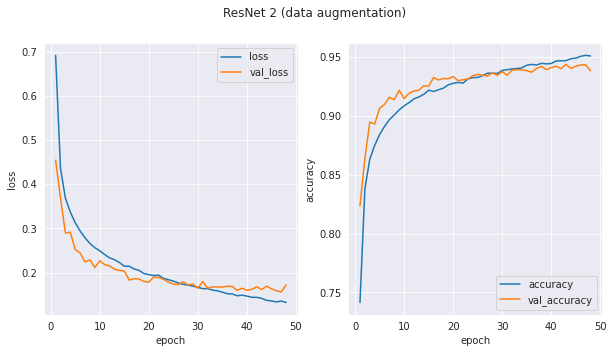

In [ ]:
# plot training history
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "loss", data=df_resnet_2_aug, label="loss")
ax[0].plot("epoch", "val_loss", data=df_resnet_2_aug, label="val_loss")
fig.axes[0].set_ylabel('loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "accuracy", data=df_resnet_2_aug, label="accuracy")
ax[1].plot("epoch", "val_accuracy", data=df_resnet_2_aug, label="val_accuracy")
fig.axes[1].set_ylabel('accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("ResNet 2 (data augmentation)")

plt.show()

---
# Triangular Learning rate scheduling

The last aspect of my models that I will attempt to optimize is the learning rate.  Rather than using a constant learning rate, I will use a [triangular learning rate policy](https://arxiv.org/pdf/1506.01186.pdf)

Additionally, I will decrease the learning rate by half whenever the validation accuracy has not improved for 3 consecutive epochs.

## VGGNet - retrain with augmented data AND triangular learning rate policy 

* triangular learning rate (with `ktrain` package)
* max LR = .001
* max epochs = 100
* early stop after 10 epochs of no improvement
* reduce max LR in half after 3 epochs of no improvement

> **Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.

In [ ]:
#load saved model
vgg_final = models.load_model(PROJECT_DIR+"vgg/tf_model.h5")
vgg_learner = ktrain.get_learner(
    vgg_final,
    train_data=(X_train, y_train), 
    val_data=(X_val, y_val), 
    batch_size=32
)

In [ ]:
#load saved training history
df_vgg_final = pd.read_csv(PROJECT_DIR+"history_vgg_final.csv")

In [ ]:
vgg_learner.evaluate(test_data=(X_test, tf.keras.utils.to_categorical(y_test)), 
                                class_names=["T-shirt", 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot'])

              precision    recall  f1-score   support

     T-shirt       0.90      0.91      0.91      1000
     Trouser       1.00      0.99      1.00      1000
    Pullover       0.93      0.93      0.93      1000
       Dress       0.95      0.95      0.95      1000
        Coat       0.92      0.94      0.93      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.86      0.82      0.84      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
        Boot       0.99      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



array([[913,   0,  15,  11,   2,   0,  56,   0,   3,   0],
       [  0, 995,   0,   4,   0,   0,   0,   0,   1,   0],
       [ 15,   1, 931,   9,  22,   0,  22,   0,   0,   0],
       [  5,   2,   6, 950,  17,   0,  19,   0,   1,   0],
       [  0,   0,  14,  14, 938,   0,  34,   0,   0,   0],
       [  0,   0,   0,   0,   0, 990,   0,   9,   0,   1],
       [ 81,   0,  35,  16,  45,   0, 820,   0,   3,   0],
       [  0,   0,   0,   0,   0,   3,   0, 984,   0,  13],
       [  2,   1,   1,   0,   1,   0,   1,   0, 994,   0],
       [  0,   0,   0,   0,   0,   8,   0,  28,   1, 963]])

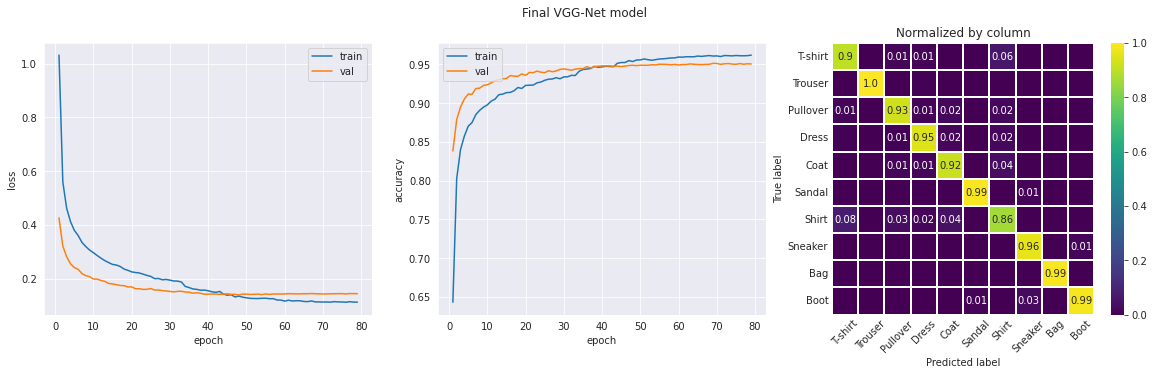

In [ ]:
training_plots(df_vgg_final, vgg_final, title="Final VGG-Net model", X_val=X_test, y_val=y_test)

In [ ]:
# evaluate model on test set
vgg_preds = vgg_final.predict(X_test)
vgg_preds = np.argmax(vgg_preds, axis=1)
print(f"VGG-Net test accuracy = {accuracy_score(y_test, vgg_preds)}"

0.9478

## ResNet - retrain with augmented data AND triangular learning rate policy

* triangular learning rate (with `ktrain` package)
* max LR = .001
* max epochs = 100
* early stop after 10 epochs of no improvement
* reduce max LR in half after 3 epochs of no improvement

> **Note:** Code used to retrain and save these models has been omitted from this notebook for the sake of readability.  It can be found in this repository's Model Training notebook.

In [ ]:
#load saved model
resnet_final = models.load_model(PROJECT_DIR+"tf_resnet_final_model.h5")
resnet_learner = ktrain.get_learner(
    resnet_final,
    train_data=(X_train, y_train), 
    val_data=(X_val, y_val), 
    batch_size=32
)

In [ ]:
#load saved training history
df_resnet_final = pd.read_csv(PROJECT_DIR+"history_resnet_final.csv")

In [ ]:
resnet_final = models.load_model(PROJECT_DIR+"tf_resnet_final_model.h5")
resnet_learner = ktrain.get_learner(
    resnet_final,
    train_data=(X_train, y_train), 
    val_data=(X_val, y_val), 
    batch_size=32
)

              precision    recall  f1-score   support

     T-shirt       0.90      0.91      0.90      1000
     Trouser       1.00      0.99      1.00      1000
    Pullover       0.93      0.93      0.93      1000
       Dress       0.94      0.95      0.95      1000
        Coat       0.90      0.94      0.92      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.86      0.82      0.84      1000
     Sneaker       0.98      0.98      0.98      1000
         Bag       0.99      0.99      0.99      1000
        Boot       0.98      0.98      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



array([[905,   0,  13,  13,   0,   1,  65,   0,   3,   0],
       [  0, 993,   0,   3,   2,   0,   1,   0,   1,   0],
       [ 10,   0, 925,  10,  30,   0,  25,   0,   0,   0],
       [  7,   1,   8, 955,  18,   0,  11,   0,   0,   0],
       [  0,   0,  16,  11, 941,   0,  32,   0,   0,   0],
       [  0,   0,   0,   0,   0, 994,   0,   4,   0,   2],
       [ 76,   0,  35,  19,  47,   0, 820,   0,   3,   0],
       [  0,   0,   0,   0,   0,   6,   0, 979,   0,  15],
       [  3,   1,   0,   1,   2,   1,   1,   0, 991,   0],
       [  0,   0,   1,   0,   0,   5,   0,  18,   0, 976]])

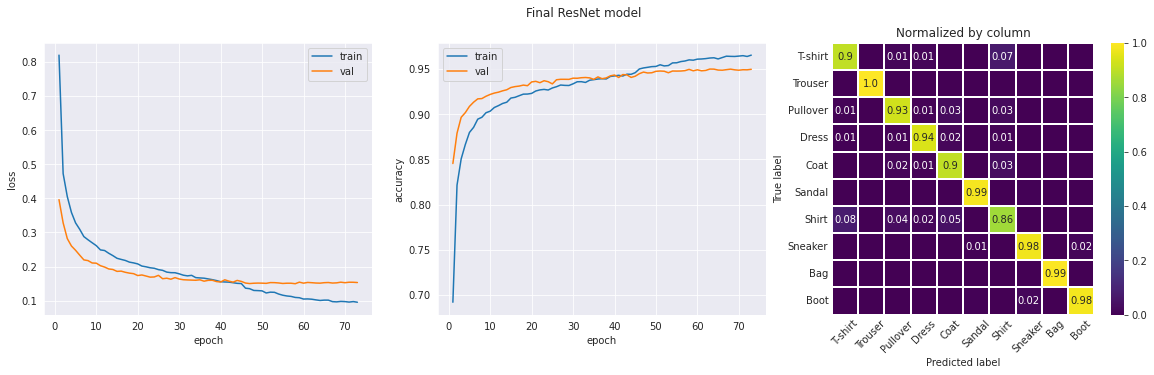

In [ ]:
training_plots(df_resnet_final, resnet_final, "Final ResNet model", X_val=X_test, y_val=y_test)

In [ ]:
# evaluate model on test set
resnet_preds = resnet_final.predict(X_test)
resnet_preds = np.argmax(resnet_preds, axis=1)
print(f"ResNet test accuracy = {accuracy_score(y_test, resnet_preds)}")

0.9479

---
# Results and discussion

## VGG_1 model iterations comparison

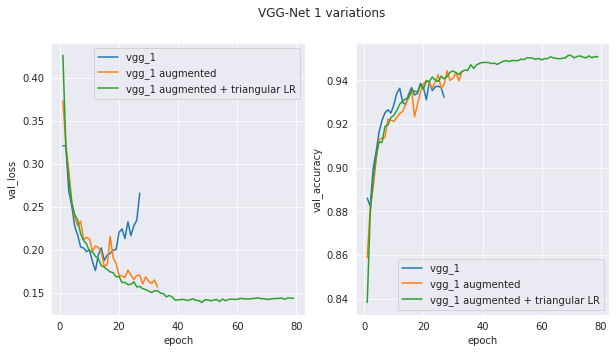

In [ ]:
# plot training history
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "val_loss", data=df_vgg_1, label="vgg_1 ")
ax[0].plot("epoch", "val_loss", data=df_vgg_1_aug, label="vgg_1 augmented")
ax[0].plot("epoch", "val_loss", data=df_vgg_final, label="vgg_1 augmented + triangular LR")
fig.axes[0].set_ylabel('val_loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "val_accuracy", data=df_vgg_1, label="vgg_1 ")
ax[1].plot("epoch", "val_accuracy", data=df_vgg_1_aug, label="vgg_1 augmented")
ax[1].plot("epoch", "val_accuracy", data=df_vgg_final, label="vgg_1 augmented + triangular LR")
fig.axes[1].set_ylabel('val_accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("VGG-Net 1 variations")

plt.show()

## ResNet 2 model iterations comparison

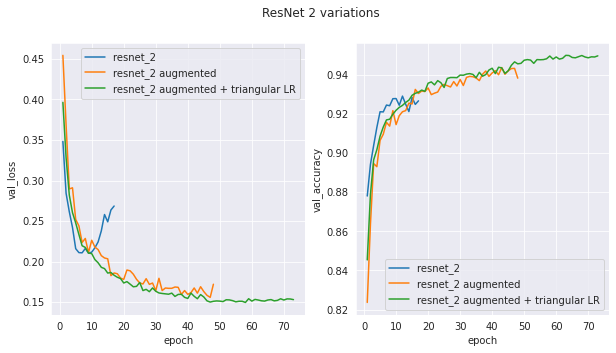

In [ ]:
# plot training history
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].plot("epoch", "val_loss", data=df_resnet_2, label="resnet_2 ")
ax[0].plot("epoch", "val_loss", data=df_resnet_2_aug, label="resnet_2 augmented")
ax[0].plot("epoch", "val_loss", data=df_resnet_final, label="resnet_2 augmented + triangular LR")
fig.axes[0].set_ylabel('val_loss')
fig.axes[0].set_xlabel('epoch')
ax[0].legend(loc='upper right')

ax[1].plot("epoch", "val_accuracy", data=df_resnet_2, label="resnet_2 ")
ax[1].plot("epoch", "val_accuracy", data=df_resnet_2_aug, label="resnet_2 augmented")
ax[1].plot("epoch", "val_accuracy", data=df_resnet_final, label="resnet_2 augmented + triangular LR")
fig.axes[1].set_ylabel('val_accuracy')
fig.axes[1].set_xlabel('epoch')
ax[1].legend(loc='lower right')

plt.suptitle("ResNet 2 variations")

plt.show()

In the end, both of my final models performed well.  


| Model | val. acc. | data aug? | LR tuning? | Test accuracy |
| --- | --- | --- | --- | --- |
| VGG-Net | 0.9332 |  |  |  |
| ResNet | 0.9392 |  |  |  |
| VGG-Net | 0.9443 | yes |  |  |
| ResNet | 0.9438 | yes |  |  |
| VGG-Net | 0.9514 | yes | yes | 0.9478 |
| ResNet | 0.9500 | yes | yes | 0.9479 |

As the table shows, data augmentation and triangular learning rate policy were very effective.  Remember, nothing else changed about the models that could explain the performance improvement, since it is extremely unlikely to attribute the improved accuracy to the randomness in initialization and data shuffling.

As expected, both models had the most difficulty with classifying torso garments: T-shirt, pullover, coat, and shirt.

## Lessons learned
Data Augmentation and Learning rate tuning are *extremely important* &mdash; or at least they were for this specific image classification task.  Cutting the validation error from .07 to .05 is a serious improvement, and implementing those techniques doesn't take much time.

Using the hyperband algorithm to tune hyperparameters appears useful, but thoughtfulness is required.  I **strongly** recommend including early stopping callbacks.  Without early stopping callbacks, the hyperparameter tuner spent 20 epochs training a model that never got above 0.20 validation accuracy...

## Future improvements

Upon further reflection, I think it was foolish to include such aggressive learning rates in my initial hyperparameter search.  I suspect that the hyperparameter search was biased in favor of models with large learning rates, because they would be likely to survive the initial round of pruning unless if their architecture was abyssmal.  Learning rate alone probably wouldn't have been enough to make a model crack the top-5, but it may have been enough to convince the tuner to "waste" time considering otherwise poor models that got off to a good start.

Still, the top candidate models from that search performed well in the end.

If I was interested in spending more compute time, there are many things I could have tried.  For example
* consider much deeper resnets
* Allow the hyperparameter tuner to search for additional epochs and consider more candidate models
* Apply hyperparameter tuning methods to the data augmentation layers

*Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms.* Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747 https://github.com/zalandoresearch/fashion-mnist